In [2]:
import os
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import h5py
import copy
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, TensorDataset, SubsetRandomSampler, ConcatDataset
from torchvision import transforms, utils, datasets
from torchmetrics import Accuracy
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from torchvision.datasets import ImageFolder
from PIL import Image
import cv2
import pyarrow.parquet as pq
import seaborn as sns
from tqdm import tqdm
from statistics import mean
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
import csv
import torchvision
import ctypes
import torch.optim as optim
from torch.optim import Adam
from functools import partial
from einops import repeat, rearrange
from einops.layers.torch import Rearrange
from timm.models.vision_transformer import PatchEmbed, Block
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, StepLR, ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler
from transformers import AutoModel, AutoTokenizer
from torch.utils.data.sampler import BatchSampler, Sampler
from skimage import io, transform
from torch.nn.utils import clip_grad_norm_

torch.manual_seed(42)
np.random.seed(42)
torch.cuda.manual_seed(42)

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
file_path_1 = '/kaggle/input/mae-unlabeled/Dataset_Specific_Unlabelled.h5'
with h5py.File(file_path_1, 'r') as file:
    X_train = file["jet"][:]
    X_train = np.array(X_train)

In [4]:
X_train.shape

(60000, 125, 125, 8)

In [5]:
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):

    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):

    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype='float32')
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [6]:
class Encoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.mask_ratio = 0.75
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        self.initialize_weights()

    def initialize_weights(self):
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        torch.nn.init.normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        
    def patchify(self, imgs):
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        noise = torch.rand(N, L, device=x.device)  
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return x_masked, mask, ids_restore
    
    def forward(self, x):
        imgs = self.patchify(x)
        x = self.patch_embed(x)
        x = x + self.pos_embed[:, 1:, :]
        x, mask, ids_restore = self.random_masking(x, self.mask_ratio)
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        return x, mask, ids_restore, imgs
    
class Decoder(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=8,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        self.num_patches = (img_size//patch_size)**2
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))
        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) 
        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))
        torch.nn.init.normal_(self.mask_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 8, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 8))
        return x

    def unpatchify(self, x):
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
        return imgs

    def forward(self, x, ids_restore):
        x = self.decoder_embed(x)
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  
        x = x + self.decoder_pos_embed
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        x = x[:, 1:, :]
        return x
    
class Masked_VIT(nn.Module):
    def __init__(self, encoder, decoder, mask_ratio):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.mask_ratio = mask_ratio
        
    def forward(self, x):
        x, mask, ids_restore, imgs = self.encoder(x)
        pred = self.decoder(x, ids_restore)
        
        return imgs, pred, mask
    
def mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75, **kwargs):
    encoder = Encoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    decoder = Decoder(
        img_size=img_size, patch_size=5, embed_dim=768, depth=8, num_heads=12,
        decoder_embed_dim=512, decoder_depth=4, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    
    model = Masked_VIT(encoder, decoder, mask_ratio)
    
    return model

model = mae_vit_base_patch16_dec512d8b(img_size=125, mask_ratio = 0.75)

In [13]:
class Custom_Dataset(Dataset):
    def __init__(self, x, transform):
        self.x = x
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_1 = (self.x[idx])
        
        if self.transform:
            img_1 = self.transform(img_1)
        sample = {'img' : img_1}
        
        return sample
    
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

dataset = Custom_Dataset(X_train, transform = transform)
sample = dataset.__getitem__(0)
print((sample['img']).shape)

torch.Size([8, 125, 125])


torch.Size([8, 125, 125])


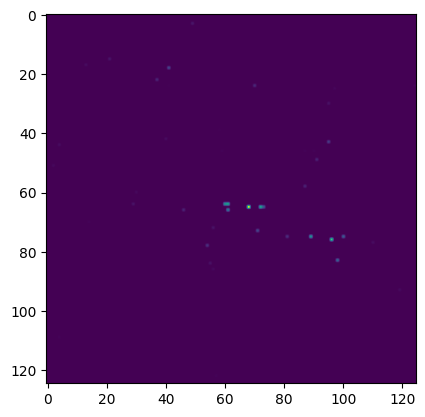

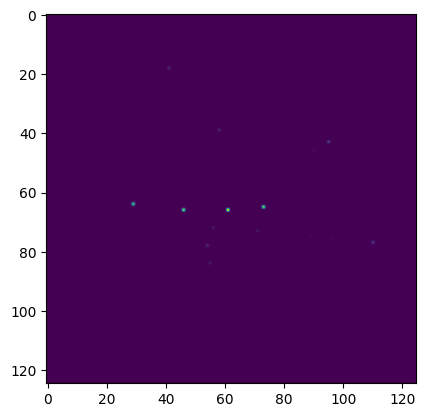

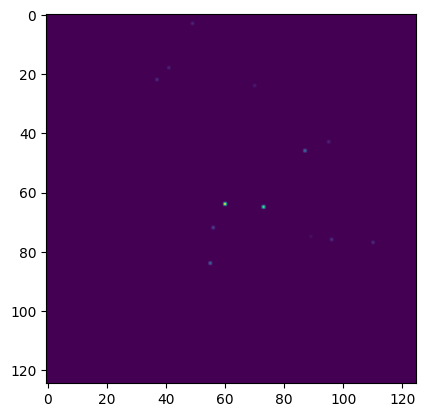

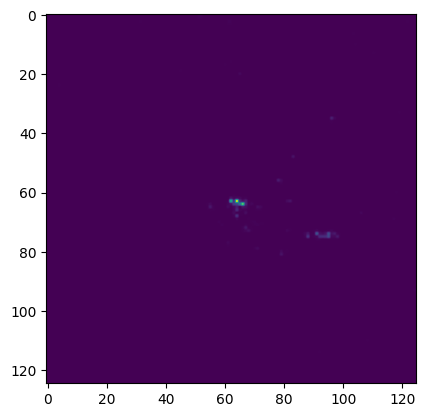

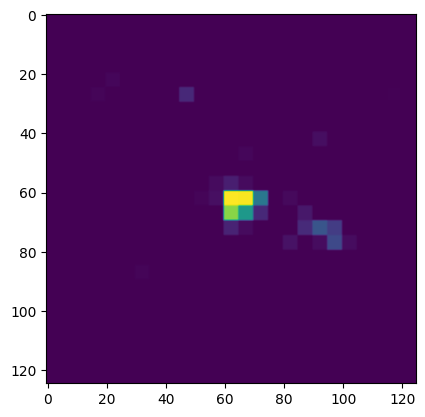

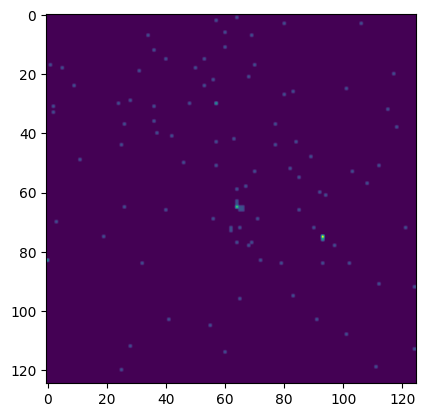

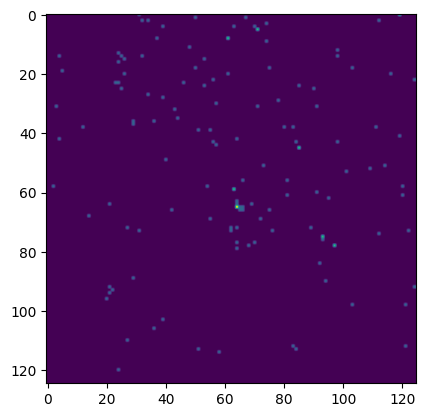

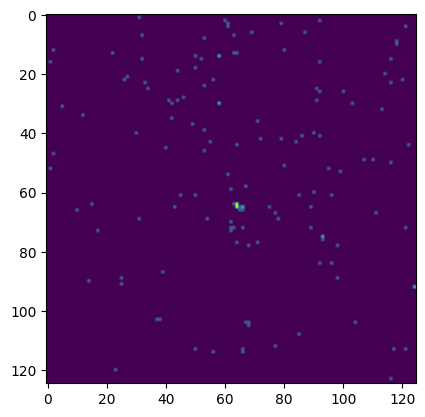

In [14]:
sample = dataset.__getitem__(0)
print((sample['img']).shape)

img = sample['img'].permute(1,2,0)
img = img.cpu().detach().numpy()

for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

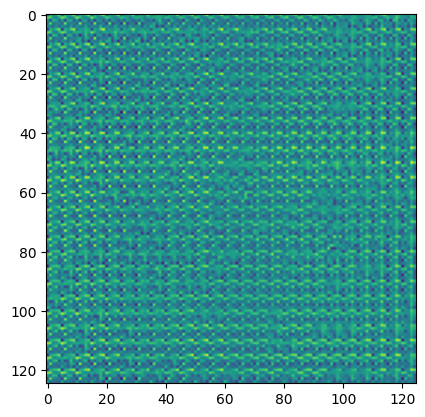

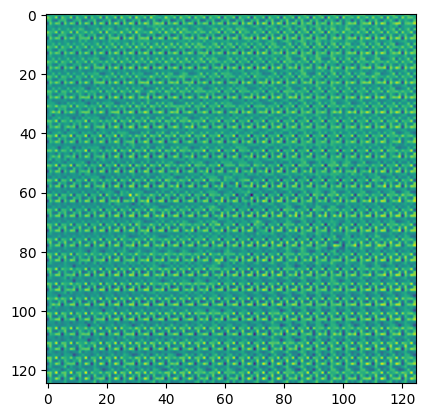

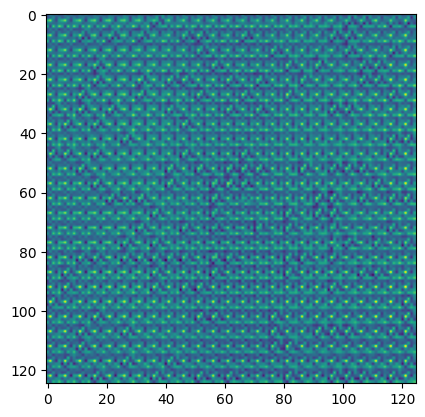

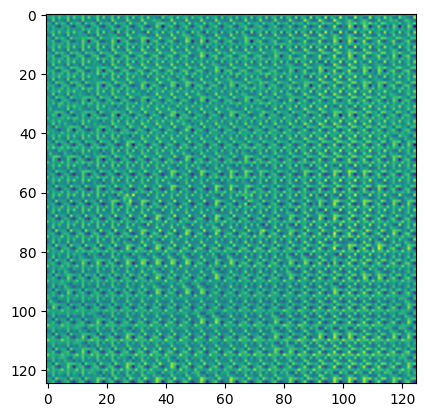

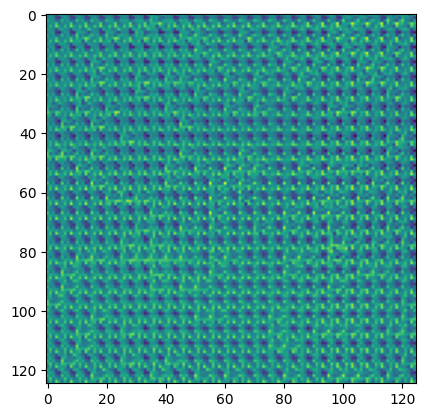

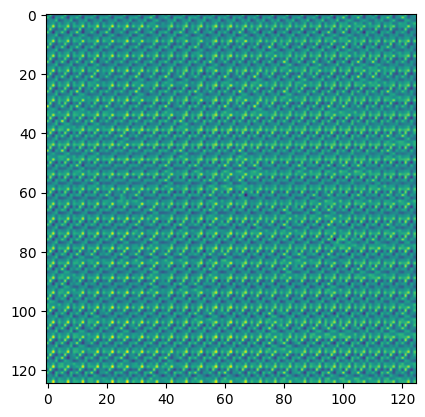

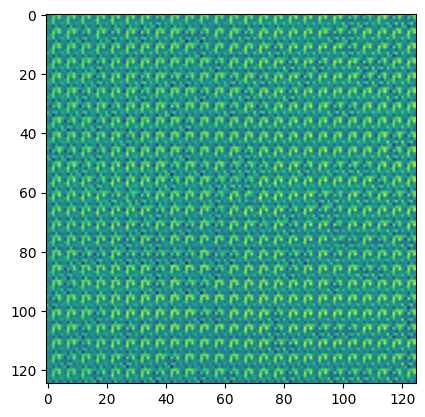

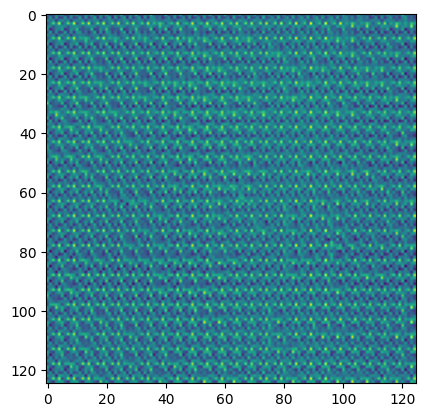

In [15]:
imgs, pred, ind = model(sample['img'].unsqueeze(0).to(device))
def unpatchify(x):
    p = 5
    h = w = int(x.shape[1]**.5)
    assert h * w == x.shape[1]
    x = x.reshape(shape=(x.shape[0], h, w, p, p, 8))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], 8, h * p, h * p))
    return imgs

pred = unpatchify(pred)
pred = pred.reshape((8, 125, 125))
img = pred.permute(1,2,0)
img = img.cpu().detach().numpy()

for i in range(8):
    plt.imshow(img[:,:,i])
    plt.show()

In [17]:
def custom_loss(imgs, pred, mask):
    
    target = imgs
    loss = (pred - target) ** 2
    loss = loss.mean(dim=-1)  
    loss = (loss * mask).sum() / mask.sum() 
    return loss

In [19]:
class CFG:
    lr = 1.5e-4 
    weight_decay = 5e-2
    num_epochs = 100
    batch_size = 64

In [23]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False)

In [24]:
optimizer = AdamW(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=40, T_mult=2)
model = mae_vit_base_patch16_dec512d8b(img_size=125)

In [25]:
train_losses = []
val_losses = []
model = model.to(device)
for epoch in range(CFG.num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    model.train()
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{CFG.num_epochs} (Train)', unit='batch'):
        inputs = batch['img'].to(device).float()

        optimizer.zero_grad()
        imgs, outputs, ind = model(inputs)
        loss = custom_loss(imgs, outputs, ind)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f'Epoch {epoch+1}/{CFG.num_epochs} (Val)', unit='batch'):
            val_inputs = batch['img'].to(device).float()

            imgs, val_outputs, ind = model(val_inputs)
            loss = custom_loss(imgs, val_outputs, ind)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    scheduler.step()

    print(f'Epoch {epoch+1}/{CFG.num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, f'./best_model.pth')

Epoch 1/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.43batch/s]


Epoch 1/80, Train Loss: 0.9470, Val Loss: 0.9181


Epoch 2/80 (Val): 100%|██████████| 188/188 [00:43<00:00,  4.32batch/s]


Epoch 2/80, Train Loss: 0.9194, Val Loss: 0.9170


Epoch 3/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.44batch/s]


Epoch 3/80, Train Loss: 0.9157, Val Loss: 0.9147


Epoch 4/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.41batch/s]


Epoch 4/80, Train Loss: 0.9123, Val Loss: 0.9100


Epoch 5/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.43batch/s]


Epoch 5/80, Train Loss: 0.9102, Val Loss: 0.9075


Epoch 6/80 (Train):  64%|██████▍   | 479/750 [05:16<02:53,  1.56batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 7/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.45batch/s]


Epoch 7/80, Train Loss: 0.9056, Val Loss: 0.9045


Epoch 8/80 (Val): 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s]


Epoch 8/80, Train Loss: 0.9010, Val Loss: 0.8977


Epoch 9/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.45batch/s]


Epoch 9/80, Train Loss: 0.8997, Val Loss: 0.8990


Epoch 10/80 (Val): 100%|██████████| 188/188 [00:41<00:00,  4.51batch/s]


Epoch 10/80, Train Loss: 0.8967, Val Loss: 0.8982


Epoch 11/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.38batch/s]


Epoch 11/80, Train Loss: 0.8954, Val Loss: 0.8977


Epoch 12/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.47batch/s]


Epoch 12/80, Train Loss: 0.8935, Val Loss: 0.8921


Epoch 13/80 (Val): 100%|██████████| 188/188 [00:42<00:00,  4.44batch/s]


Epoch 13/80, Train Loss: 0.8932, Val Loss: 0.8909


Epoch 14/80 (Val): 100%|██████████| 188/188 [00:41<00:00,  4.53batch/s]


Epoch 14/80, Train Loss: 0.8906, Val Loss: 0.8913


Epoch 15/80 (Val): 100%|██████████| 188/188 [00:43<00:00,  4.36batch/s]


Epoch 15/80, Train Loss: 0.8905, Val Loss: 0.8910


Epoch 16/80 (Train):  74%|███████▍  | 555/750 [06:09<02:10,  1.49batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 45/80 (Val): 100%|██████████| 188/188 [00:46<00:00,  4.03batch/s]


Epoch 45/80, Train Loss: 0.8828, Val Loss: 0.8831


Epoch 46/80 (Val): 100%|██████████| 188/188 [00:44<00:00,  4.24batch/s]


Epoch 46/80, Train Loss: 0.8827, Val Loss: 0.8832


Epoch 47/80 (Val): 100%|██████████| 188/188 [00:46<00:00,  4.03batch/s]s]


Epoch 47/80, Train Loss: 0.8826, Val Loss: 0.8851


Epoch 48/80 (Val): 100%|██████████| 188/188 [00:46<00:00,  4.04batch/s]


Epoch 48/80, Train Loss: 0.8811, Val Loss: 0.8820


Epoch 49/80 (Val): 100%|██████████| 188/188 [00:46<00:00,  4.05batch/s]


Epoch 49/80, Train Loss: 0.8815, Val Loss: 0.8824


Epoch 50/80 (Val):  94%|█████████▎| 176/188 [00:43<00:03,  3.86batch/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [27]:
encoder = model.module.encoder
torch.save(encoder, 'encoder.pth')
torch.save(model.module, 'model.pth')

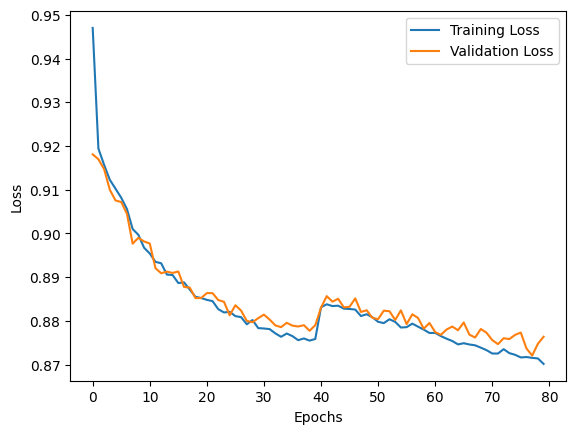

In [32]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()